### SaudiViz "1" Flights that Departed NYC in 2013

In this notebook I have did important data engineering steps as extract, transform, and load the data and my main objective from that is to prepare dataset that have the needed information about the delay of flights

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
flights = pd.read_csv('Flights.csv')
airlines = pd.read_csv('airlines.csv') 
airports = pd.read_csv('airports.csv')
weather = pd.read_csv('weather.csv')
planes = pd.read_csv('planes.csv')

In [3]:
# Engineer 4 featrures about earler or delay 

flights['dep_earler_fix'] = flights.dep_delay.apply(lambda x:0 if x>0 else x*-1)
flights['arr_earler_fix'] = flights.arr_delay.apply(lambda x:0 if x>0 else x*-1)
flights['dep_delay_fix'] = flights.dep_delay.apply(lambda x:0 if x<0 else x)
flights['arr_delay_fix'] = flights.arr_delay.apply(lambda x:0 if x<0 else x)

In [4]:
# Engineer date feature and genrete day anme and month

flights['date'] = flights.year.map(str) + '-' + flights.month.map(str)+ '-' + flights.day.map(str)
flights['date'] = pd.to_datetime(flights['date'])
flights['day_name'] = flights['date'].dt.day_name()
flights['month_name'] = flights['date'].dt.month_name()

In [5]:
# Choose needed columns

flights_carrier = flights[['carrier', 'dep_earler_fix', 'arr_earler_fix', 'dep_delay_fix',
                          'arr_delay_fix', 'air_time', 'distance', 'origin', 'dest',
                           'hour', 'day_name' ,'month_name', 'time_hour', 'tailnum', 'date']]

#### Let's merge airports data for origin_airport_name using dest code

In [6]:
airports_city = airports[['faa', 'tzone', 'name']]

flights_airports = pd.merge(flights_carrier, airports_city,
                            how='left', left_on='dest', right_on='faa')

flights_airports = flights_airports.drop(['faa', 'dest'], axis =1)

flights_airports = pd.merge(flights_airports, airports_city, how='left',
                            left_on='origin', right_on='faa')

flights_airports = flights_airports.drop(['faa', 'tzone_y'], axis =1)

flights_airports.rename(columns={"tzone_x": "dest_city", "name_x": "dest_airport_name",
                                 "name_y": "origin_airport_name"}, inplace =True)


#### Let's merge weather data using time_hour code

In [7]:
weather['date'] = weather.year.map(str) + '-' + weather.month.map(str)+ '-' + weather.day.map(str)
weather['date'] = pd.to_datetime(weather['date'])
weather.head()
weather_group = weather.groupby(['date','origin','hour']).mean()[['dewp', 'temp', 'humid', 'wind_dir', 'wind_speed', 'precip', 'pressure', 'visib']]

flights_weather = pd.merge(flights_airports, weather_group,
                           on = ['date', 'origin', 'hour'], how = 'left' )


**We will fix carrier name insted of code**

In [8]:
flights_final = pd.merge(flights_weather, airlines, how='left',
                           left_on='carrier', right_on='carrier')

flights_final = flights_final.drop(['carrier'], axis =1)
flights_final.rename(columns={"name": "carrier_name"}, inplace =True)


**Let's add plane model**

In [9]:
flights_final.tailnum.fillna('unknown',inplace=True)
planes['year'] =  pd.to_numeric(planes['year'])
planes['seats'] =  pd.to_numeric(planes['seats'])
planes['engines'] =  pd.to_numeric(planes['engines'])

planes.loc[3322] = ['unknown', planes.year.mean() , 'unknown', 'unknown', 'unknown',
                    planes.engines.mean(), planes.seats.mean(), 'unknown','unknown']

final = pd.merge(flights_final, planes, how='left', on='tailnum')


## Checking null values:
In next section will see how null exist in our data and then will take actions about them, let's go:

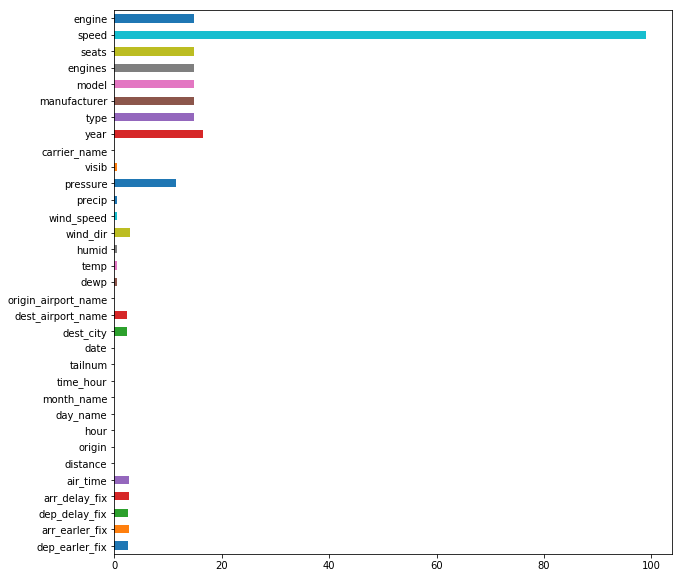

In [10]:
Nan_flifhts = final.isnull().sum(axis = 0)
nan_pres = Nan_flifhts/final.shape[0] * 100
nan_pres.plot.barh(figsize=(10, 10));

#### Let's do some impution steps to handling missing data

In [11]:
df = final.drop(['speed', 'tailnum'], axis =1)

impute_str = ['engine', 'model', 'manufacturer', 'type', 'dest_airport_name' ,'dest_city']
for col_name in impute_str:
    df[col_name] = df[col_name].fillna('unknown')

impute_numbs_weth = ['pressure', 'temp', 'wind_dir',
                   'dewp', 'humid', 'wind_speed',
                   'precip', 'visib']

for col_name in impute_numbs_weth:
    df[col_name] = pd.to_numeric(df[col_name])
    df[col_name] = df[col_name].groupby(df["date"]).transform(lambda x: x.fillna(x.mean()))
    df[col_name] = df[col_name].fillna(df[col_name].mean())
    
impute_numbs = ['year', 'seats', 'engines']
for col_name in impute_numbs:
    df[col_name] = pd.to_numeric(df[col_name])
    df[col_name] = df[col_name].fillna(df[col_name].mean())
    
df.isnull().sum(axis = 0)

dep_earler_fix         8255
arr_earler_fix         9430
dep_delay_fix          8255
arr_delay_fix          9430
air_time               9430
distance                  0
origin                    0
hour                      0
day_name                  0
month_name                0
time_hour                 0
date                      0
dest_city                 0
dest_airport_name         0
origin_airport_name       0
dewp                      0
temp                      0
humid                     0
wind_dir                  0
wind_speed                0
precip                    0
pressure                  0
visib                     0
carrier_name              0
year                      0
type                      0
manufacturer              0
model                     0
engines                   0
seats                     0
engine                    0
dtype: int64

In [12]:
# Since we foucs about dealy we will delete nan's rows

drop_rows_feats = ['dep_earler_fix', 'arr_earler_fix', 'dep_delay_fix', 'arr_delay_fix', 'air_time']
count_rows = 0
for col_name in drop_rows_feats:
    rows = df[df[col_name].isnull()].index
    count_rows = count_rows + len(rows)
    df = df.drop(rows)
count_rows

9430

#### Let's see how nan's values fixed now

In [13]:
df.isnull().sum(axis = 0)

dep_earler_fix         0
arr_earler_fix         0
dep_delay_fix          0
arr_delay_fix          0
air_time               0
distance               0
origin                 0
hour                   0
day_name               0
month_name             0
time_hour              0
date                   0
dest_city              0
dest_airport_name      0
origin_airport_name    0
dewp                   0
temp                   0
humid                  0
wind_dir               0
wind_speed             0
precip                 0
pressure               0
visib                  0
carrier_name           0
year                   0
type                   0
manufacturer           0
model                  0
engines                0
seats                  0
engine                 0
dtype: int64

## Data ready for analysis

#### Frist we will create new features calcuate delay and earler

In [14]:
df['delay'] = df.dep_delay_fix + df.arr_delay_fix
df['earler'] = df.dep_earler_fix + df.arr_earler_fix

#### Let's calcuate the delay minutes and mean for carrier

In [15]:
carrier = ['AirTran Airways Corporation', 'Alaska Airlines Inc.',
       'American Airlines Inc.', 'Delta Air Lines Inc.', 'Endeavor Air Inc.',
       'Envoy Air', 'ExpressJet Airlines Inc.', 'Frontier Airlines Inc.',
       'Hawaiian Airlines Inc.', 'JetBlue Airways', 'Mesa Airlines Inc.',
       'SkyWest Airlines Inc.', 'Southwest Airlines Co.', 'US Airways Inc.',
       'United Air Lines Inc.', 'Virgin America']

carrier_earler_count = df.groupby('carrier_name').count()['delay'].reindex(carrier)
carrier_delay_mins = df.groupby('carrier_name').sum()['delay'].reindex(carrier)
carrier_earler_mins = df.groupby('carrier_name').sum()['earler'].reindex(carrier)
carrier_delay_mean = df.groupby('carrier_name').mean()['delay'].reindex(carrier)
carrier_earler_mean = df.groupby('carrier_name').mean()['earler'].reindex(carrier)

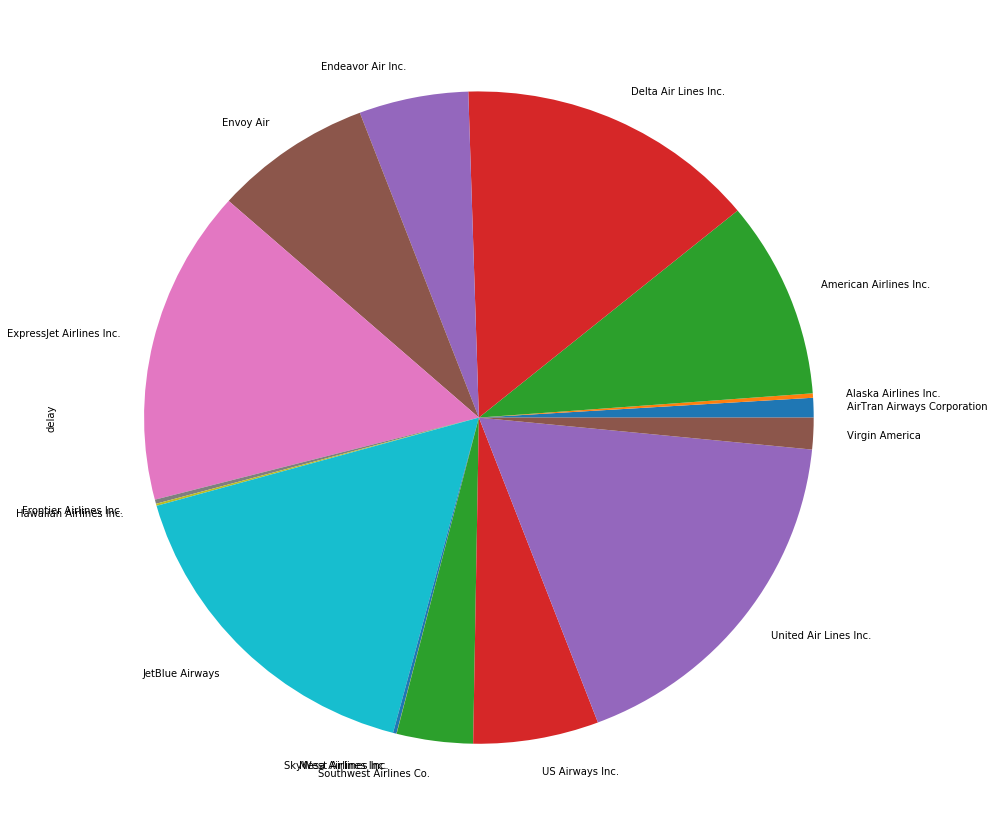

In [18]:
# Carrier counts pie chart
carrier_earler_count.plot(kind = 'pie',figsize=(15,15));

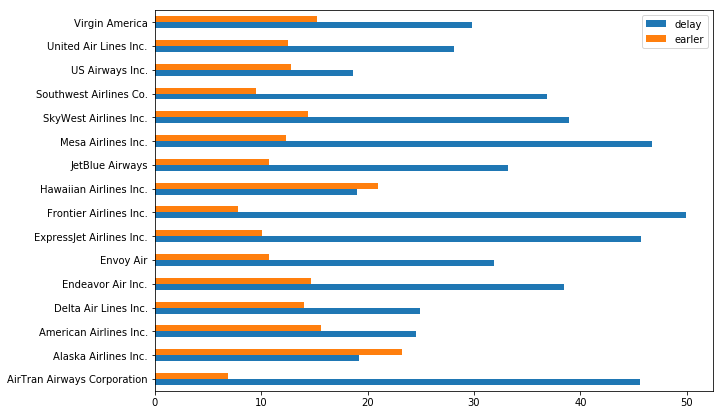

In [19]:
#Compare between mean of delay and earler

delay = carrier_delay_mean.values
earler = carrier_earler_mean.values
day_plot = pd.DataFrame({'delay': delay, 'earler': earler}, index= carrier)
day_plot.plot.barh(figsize=(10,7));

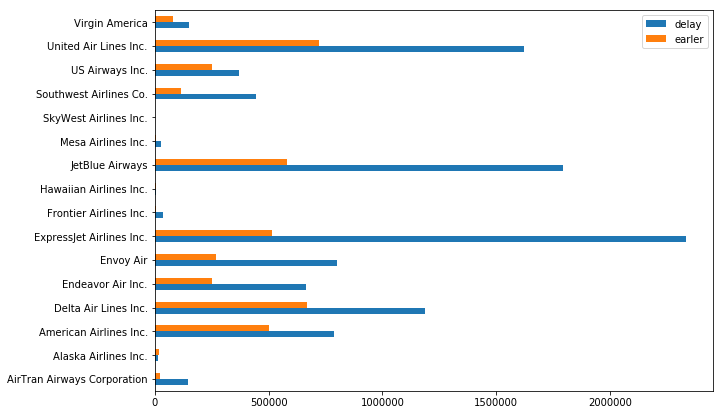

In [20]:
#Compare between minutes of delay and earler

delay = carrier_delay_mins.values
earler = carrier_earler_mins.values
day_plot = pd.DataFrame({'delay': delay, 'earler': earler}, index= carrier)
day_plot.plot.barh(figsize=(10,7));

#### Genral statstics about delay and earler mean 

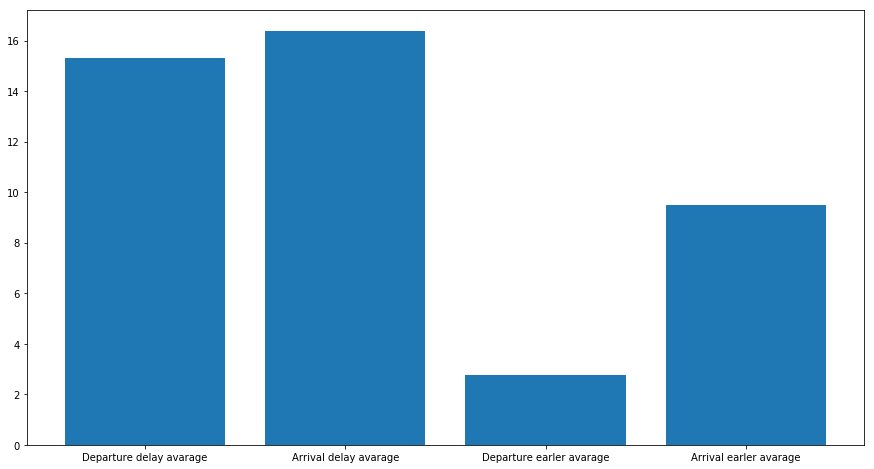

In [21]:
delay_earler_sum = {'Departure delay avarage' : df.dep_delay_fix.sum() / df.dep_delay_fix.count(),
             'Arrival delay avarage' : df.arr_delay_fix.sum() / df.arr_delay_fix.count(),
            'Departure earler avarage' : df.dep_earler_fix.sum() / df.dep_earler_fix.count(),
             'Arrival earler avarage' : df.arr_earler_fix.sum() / df.arr_earler_fix.count() }

plt.figure(figsize=(15, 8))
plt.bar(range(len(delay_earler_sum)), list(delay_earler_sum.values()), align='center')
plt.xticks(range(len(delay_earler_sum)), list(delay_earler_sum.keys()))

plt.show();

#### Genral stastics about delay and earler for day, month, and hour

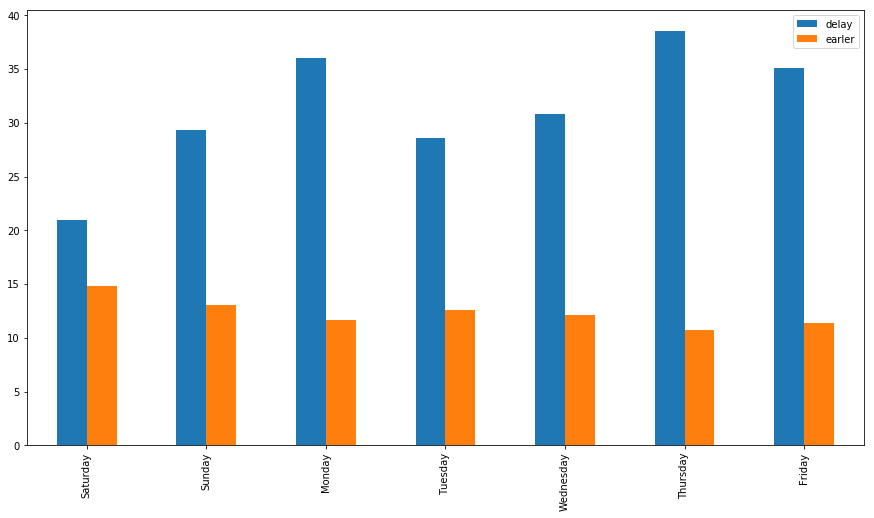

In [22]:
days = ['Saturday', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday','Thursday', 'Friday']

day_delay_mean = df.groupby('day_name').mean()['delay'].reindex(days)
day_earler_mean = df.groupby('day_name').mean()['earler'].reindex(days)

delay = day_delay_mean.values
earler = day_earler_mean.values
day_plot = pd.DataFrame({'delay': delay, 'earler': earler}, index= days)
day_plot.plot.bar(figsize=(15,8));

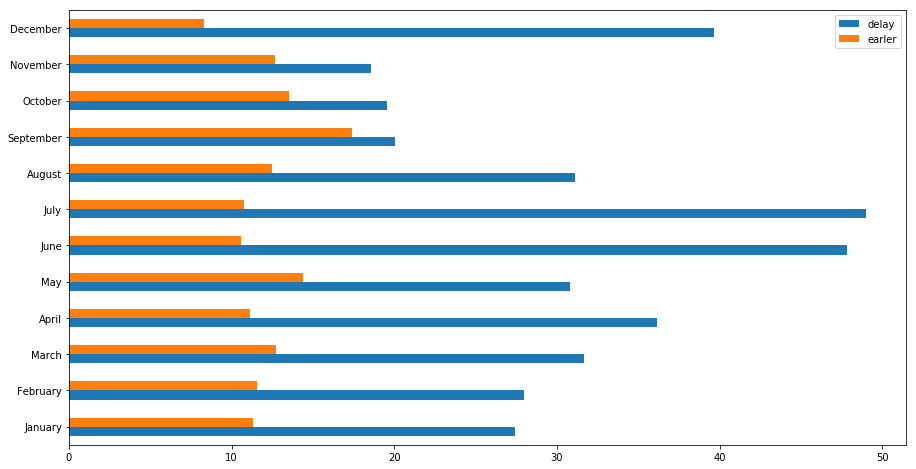

In [23]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
       'August', 'September', 'October', 'November', 'December']

month_delay_mean = df.groupby('month_name').mean()['delay'].reindex(months)
month_earler_mean = df.groupby('month_name').mean()['earler'].reindex(months)


delay = month_delay_mean.values
earler = month_earler_mean.values

month_plot = pd.DataFrame({'delay': delay, 'earler': earler}, index=months)
month_plot.plot.barh(figsize=(15,8));

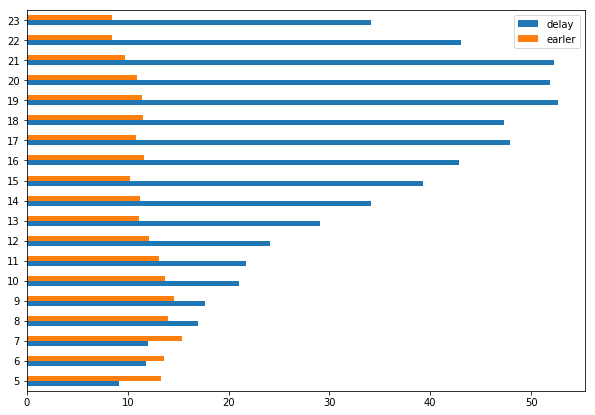

In [24]:
hour_delay_mean = df.groupby('hour').mean()['delay']
hour_earler_mean = df.groupby('hour').mean()['earler']

hour_delay = hour_delay_mean.values
hour_earler = hour_earler_mean.values

index = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
            23]
df3 = pd.DataFrame({'delay': hour_delay, 'earler': hour_earler}, index=index)
df3.plot.barh(figsize=(10,7));

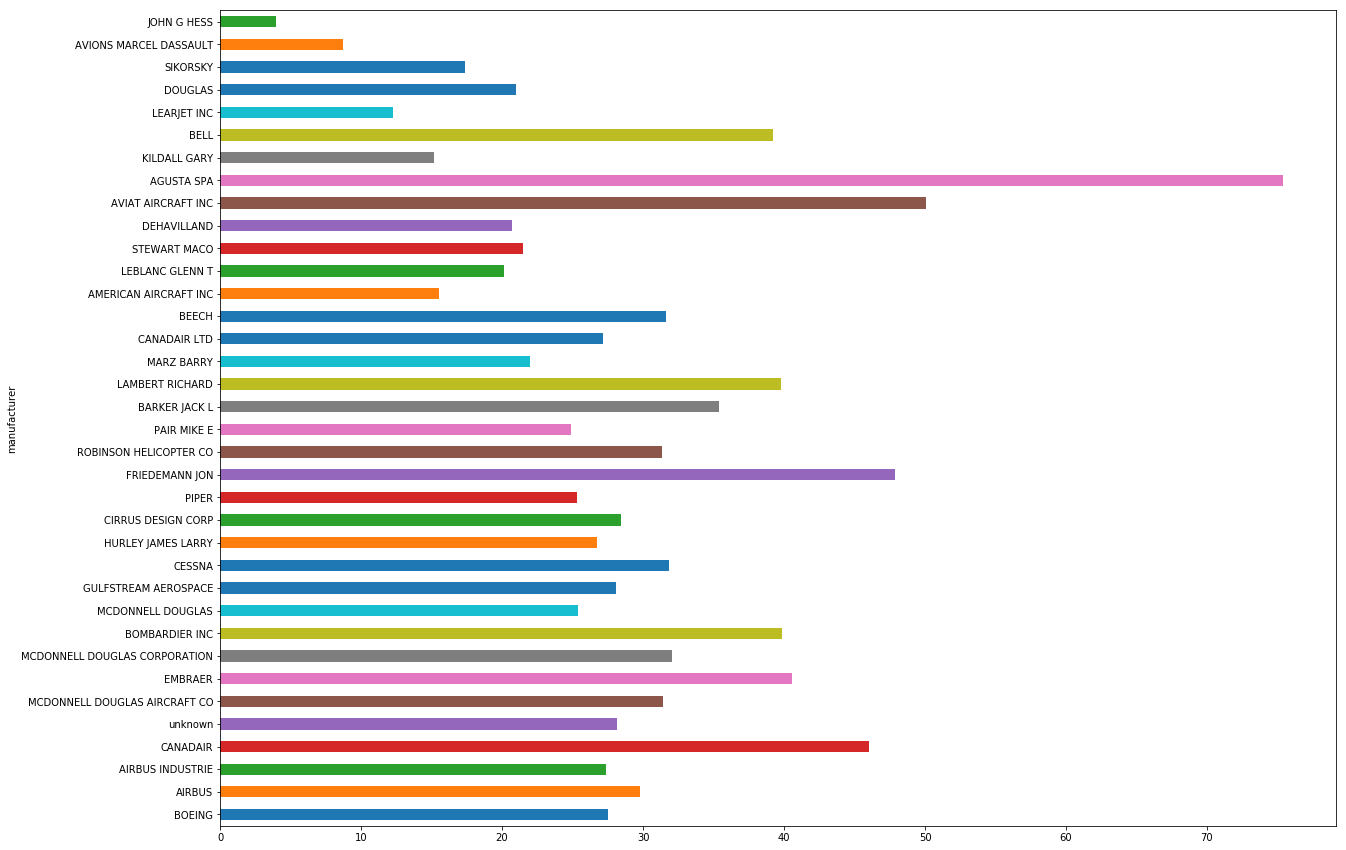

In [28]:
# Plane manufacturer mean delay chart

df.groupby('manufacturer', sort=False).mean()['delay'].plot.barh(figsize=(20,15));